## Sentiment analysis with few plots for the EDA

In [1]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('data.csv')
df['Title'] = df['Title'].astype(str)
df['Body'] = df['Body'].astype(str)

In [3]:
list_title = df['Title'].to_list()
stopwords = nltk.corpus.stopwords.words('italian')
words_title = [word for text in list_title for word in nltk.word_tokenize(text)]
words_title_clear = [w for w in words_title if w not in stopwords]

## Most common words in titles and bodies

In [4]:
fd_title = nltk.FreqDist(words_title_clear)

sorted_fd_title = dict(sorted(fd_title.items(), key=lambda item: item[1], reverse=True))

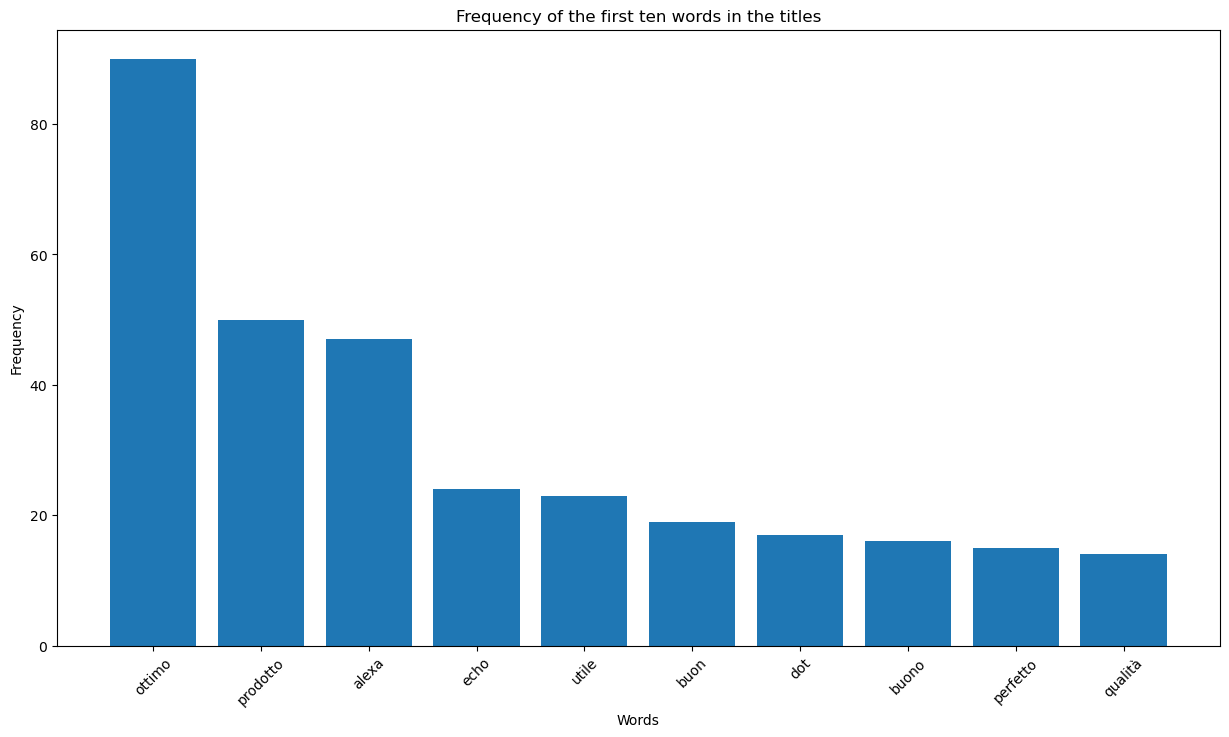

In [5]:
plt.figure(figsize=(15,8))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Frequency of the first ten words in the titles')
plt.bar(list(sorted_fd_title.keys())[:10], list(sorted_fd_title.values())[:10])
plt.show()

In [6]:
list_body = df['Body'].to_list()
list_body = [str(word) for word in list_body]
words_body = [word for text in list_body for word in nltk.word_tokenize(text)]
words_body_clear = [w for w in words_body if w.lower() not in stopwords]

In [7]:
fd_body = nltk.FreqDist(words_body_clear)

sorted_fd_body = dict(sorted(fd_body.items(), key=lambda item: item[1], reverse=True))

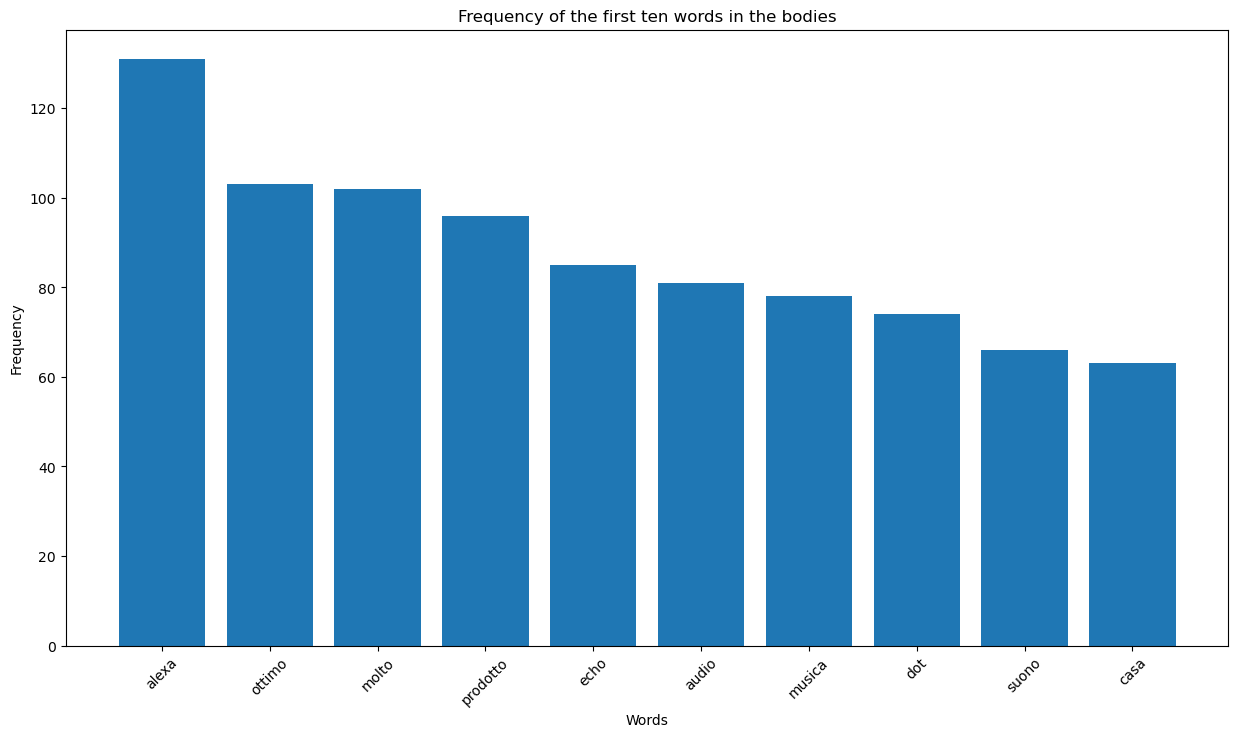

In [8]:
plt.figure(figsize=(15,8))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Frequency of the first ten words in the bodies')
plt.bar(list(sorted_fd_body.keys())[:10], list(sorted_fd_body.values())[:10])
plt.show()

## Word Plots for positive and neutral reviews

In [9]:
positive_reviews = df[df['Stars'] >= 4]['Title']
positive_reviews = ".".join(positive_reviews)

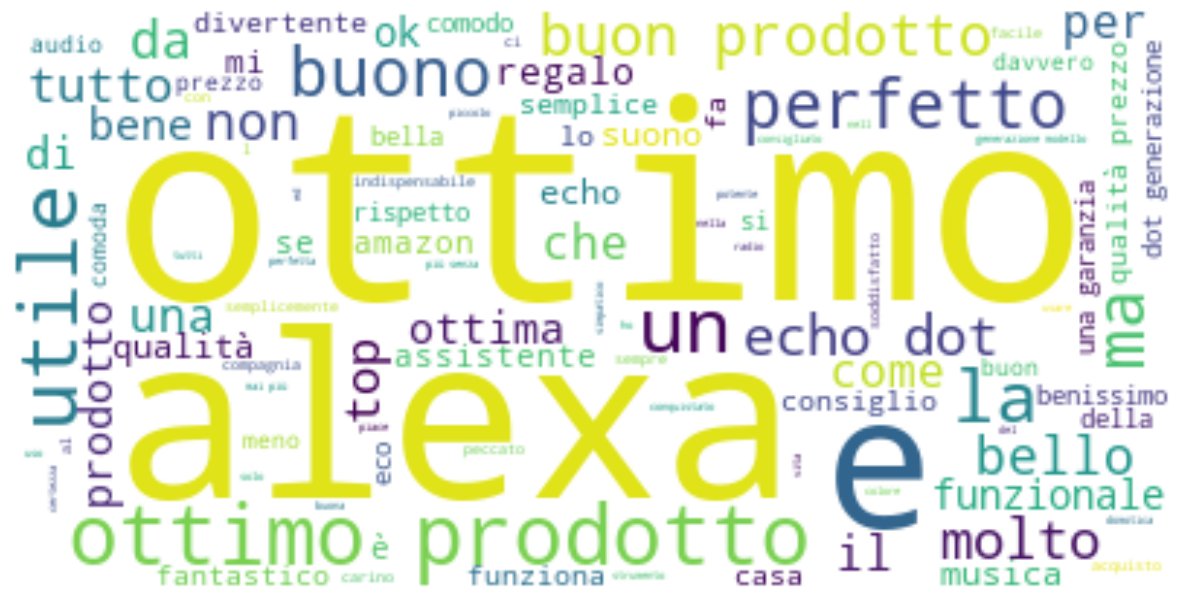

In [10]:
wordcloud = WordCloud(background_color="white", max_words=len(positive_reviews))

wordcloud.generate(positive_reviews)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
neutral_reviews = df[df['Stars'] == 3]['Title']
neutral_reviews = ".".join(neutral_reviews)

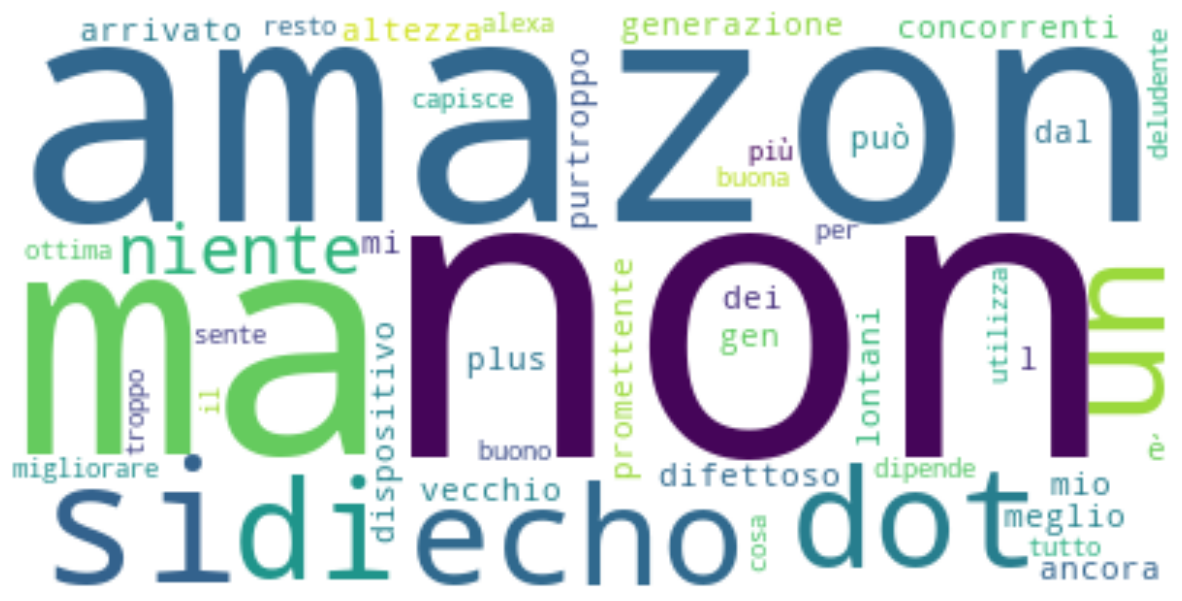

In [12]:
wordcloud = WordCloud(background_color="white", max_words=len(neutral_reviews))

wordcloud.generate(neutral_reviews)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Review classification

In [13]:
sia = SentimentIntensityAnalyzer()
title_polarity = [sia.polarity_scores(str(element)) for element in df['Title']]
body_polarity = [sia.polarity_scores(str(element)) for element in df['Body']]

In [14]:
title_pol_mean = []

for i in range(len(title_polarity)):
    if title_polarity[i]['compound'] == 0.0:
        title_pol_mean.append(0.5)
    else:
        title_pol_mean.append(title_polarity[i]['compound'])

In [15]:
body_pol_mean = []

for i in range(len(body_polarity)):
    if body_polarity[i]['compound'] == 0.0:
        body_pol_mean.append(0.5)
    else:
        body_pol_mean.append(body_polarity[i]['compound'])

In [16]:
total_polarity = []
total_polarity = [round((i*0.2 + j*0.8)/2, 4) for i,j in zip(title_pol_mean, body_pol_mean)]

In [17]:
df['Polarity'] = total_polarity

In [18]:
list_polarity = []
for i in range(len(df)):
    if df['Polarity'][i] < 0:
        list_polarity.append('Bad')
    elif df['Polarity'][i] <= 0.15:
        list_polarity.append('Neutral')
    else:
        list_polarity.append('Good')

df['Polarity_Text'] = list_polarity

In [19]:
df['Polarity_Text'].value_counts()

Good       406
Bad         66
Neutral     38
Name: Polarity_Text, dtype: int64

In [20]:
df['Full Review'] = df.apply(lambda row: row['Title'] + ' ' + row['Body'], axis=1)

In [21]:
df.sample(10)

,Title,Body,Stars,Polarity,Polarity_Text,Full Review
89,alexa gen ottimo come gli altri alexa,ho perso il conto di quanti echo dot ho compra...,5,0.2500,Good,alexa gen ottimo come gli altri alexa ho per...
310,inimitabile,bello piccolo e potente utile e versatile t...,5,0.2500,Good,inimitabile bello piccolo e potente utile e ...
263,ottimo,da scoprire le funzionalità del dispositivo,4,0.2500,Good,ottimo da scoprire le funzionalità del disposi...
24,è un regalo,l ho scelto come regalo per ora era felice ...,5,0.2500,Good,è un regalo l ho scelto come regalo per ora e...
294,ottimo e semplice da usare e utile,questo è il secondo che ho acquistato oltre a...,5,0.2500,Good,ottimo e semplice da usare e utile questo è i...
45,utile,buon promemoria per spese sveglie e compleanni,5,0.2500,Good,utile buon promemoria per spese sveglie e comp...
441,sempre piu alexa,alexa è sempre alexa riconoscimento vocale al...,5,0.1309,Neutral,sempre piu alexa alexa è sempre alexa riconos...
336,bel prodotto,alexa e un ottimo prodotto può essere usato p...,5,0.2500,Good,bel prodotto alexa e un ottimo prodotto può e...
269,ottimo,funziona benissimo,5,0.2500,Good,ottimo funziona benissimo
39,buon prodotto,audio un po cupo,4,-0.1730,Bad,buon prodotto audio un po cupo


## Dense Matrix to feed the models

In [22]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['Full Review'])
feature_names = vectorizer.get_feature_names_out()
matrix = vectors.todense()
list_dense = matrix.tolist()
sparse_matrix = pd.DataFrame(list_dense, columns=feature_names)

In [23]:
sparse_matrix['Polarity_Text'] = list_polarity

In [24]:
sparse_matrix.shape

(510, 2603)

In [25]:
sparse_matrix.sample(10)

,abbassare,abbasso,abbastanza,abbia,abbiamo,abbiano,abbina,abbinabili,abbinamento,abbinandolo,...,vuole,web,wi,wifi,wireless,wow,xd,youtube,zio,Polarity_Text
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bad
477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good


## Writing dataframe and sparse matrix into two files

In [24]:
df.to_csv('data_final.csv', index=False)

In [25]:
sparse_matrix.to_csv('matrix.csv', index=False)